In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint, sample
from scipy.linalg import subspace_angles
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
%matplotlib inline

In [2]:
WS_LOC = '../../data/subspaces/goi5k/'

In [3]:
def get_subspace(folder: str = WS_LOC, index = None) -> np.ndarray:
    npy_subspaces = os.listdir(WS_LOC)
    if index is None:
        index = randint(0, len(npy_subspaces))
    S = np.load(os.path.join(WS_LOC, npy_subspaces[index]))
    return S

def sample_subspaces(folder: str = WS_LOC, count: int = 10):
    sample_subs = sample(population=os.listdir(WS_LOC),k=count)
    return np.asarray([np.load(os.path.join(WS_LOC, sub)) for sub in sample_subs], dtype=np.float32)
#     return [np.load(os.path.join(WS_LOC, sub)) for sub in sample_subs]

def subspaces_similarity(S1, S2):
    canon_angles = subspace_angles(S1, S2)
    return np.average(np.square(np.cos(canon_angles)))

In [4]:
sub_one = get_subspace()
sub_two = get_subspace()
sim = subspaces_similarity(S1=sub_one, S2=sub_two)

## Compute the condensed distance matrix

#### Distance Function:
    D(x, y) = 1 - S(x, y), where 0 <= S <= 1

In [5]:
def condensed_dist(subs):
    n = subs.shape[0]
    dm = []
    for i in range(n):
        s_i = subs[i]
        dm.extend([1 - subspaces_similarity(S1=s_i, S2=subs[j]) for j in range(i+1, n)])
    return np.array(dm)

## Scipy Dendrogram

https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

In [6]:
count = 10
labels = range(0, count)
subs = sample_subspaces(count=count)
dm = condensed_dist(subs)

In [7]:
linked = linkage(y=dm, method='complete')
linked

array([[ 2.        ,  7.        ,  0.78265217,  2.        ],
       [ 6.        ,  9.        ,  0.81760551,  2.        ],
       [ 8.        , 11.        ,  0.90794597,  3.        ],
       [10.        , 12.        ,  0.92303637,  5.        ],
       [ 1.        ,  5.        ,  0.93075906,  2.        ],
       [ 0.        ,  3.        ,  0.93189354,  2.        ],
       [ 4.        , 15.        ,  0.941203  ,  3.        ],
       [14.        , 16.        ,  0.97340991,  5.        ],
       [13.        , 17.        ,  0.97633583, 10.        ]])

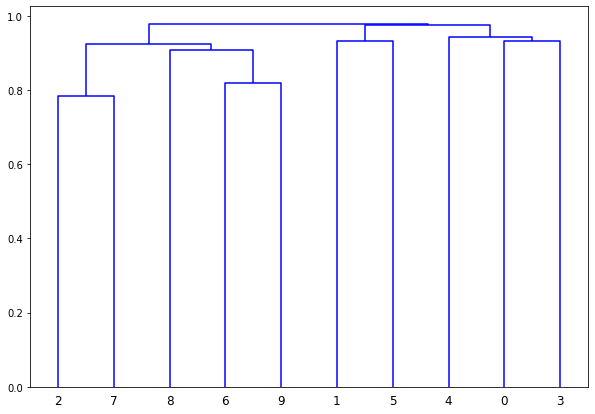

In [8]:
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labels,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

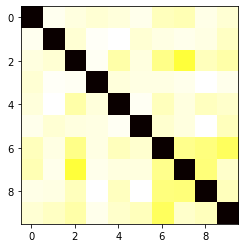

In [9]:
s_dm = squareform(dm)
plt.imshow(s_dm, cmap='hot', interpolation='nearest')
plt.show()

## Clustering

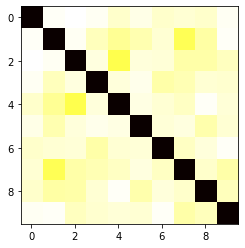

In [10]:
subs = sample_subspaces(count=10)
dm = condensed_dist(subs)
s_dm = squareform(dm)
plt.imshow(s_dm, cmap='hot', interpolation='nearest')
plt.show()

In [11]:
n_clusters = 4
affinity = 'precomputed'
lnkg = 'complete' # single or complete
compute_full_tree = 'auto'
if n_clusters is not None:
    distance_threshold = None
else:
    distance_threshold = 0.85
ac = AgglomerativeClustering(n_clusters=n_clusters, 
                             affinity=affinity, 
                             linkage=lnkg,
                             compute_full_tree=compute_full_tree, 
                             distance_threshold=distance_threshold)
ac.fit(s_dm)
print(f'Number of clusters: {ac.n_clusters_}')

Number of clusters: 4


In [12]:
labels = ac.labels_
labels

array([3, 0, 2, 0, 2, 1, 0, 0, 1, 1])

In [13]:
i = 4
j = -1
subspaces_similarity(subs[i], subs[j])

0.060745787

### Create clusters

In [113]:
clusters = {}
for s, l in zip(subs, labels):
    if l not in clusters:
        clusters[l] = Cluster(label=l, subspace=s)
    else:
        clusters[l].add(s)

In [118]:
clusters[3].distance(subs[-3])

0.0

## Searching for an approximate nearest neighbour

In [99]:
class Cluster:
    
    def __init__(self, label: int, subspace):
        self.label =label
        self.size = 1
        self.subspaces = np.expand_dims(subspace, axis=0)
        self.rep = subspace
    
    def __repr__(self):
        return f'Cluster-{self.label}'
    
    def __lt__(self, other):
        return True
    
    def __eq__(self, other):
        return True
    
    def distance(self, other):
        # other is subspace (300, 5)
        return 1 - subspaces_similarity(S1=self.rep, S2=other)
    
    def add(self, subspace):
        self.subspaces = np.append(self.subspaces, np.expand_dims(subspace, axis=0), axis=0)
        self.size += 1
        self.compute_rep()
        
    def compute_rep(self):
        self.rep = np.mean(self.subspaces, axis=0, dtype=np.float64)
    
    def get_rep(self):
        return self.rep

class Index:
    
    def __init__(self, subspaces: np.ndarray):
        pass

In [21]:
a = np.random.rand(2, 3)
b = np.random.rand(2, 3)
print(a)
print(b)

[[0.84569634 0.84222532 0.13376251]
 [0.89899966 0.33340296 0.71435069]]
[[0.61785766 0.27817323 0.25958679]
 [0.99389378 0.40930107 0.04043242]]


In [22]:
cluster = Cluster(subspace=a)
rep = cluster.get_rep()
print(f'Rep:\n{rep}')
# cluster.add(a)
cluster.add(b)
rep = cluster.get_rep()
print(f'Rep:\n{rep}')

cluster.subspaces

Rep:
[[0.84569634 0.84222532 0.13376251]
 [0.89899966 0.33340296 0.71435069]]
Rep:
[[0.731777   0.56019928 0.19667465]
 [0.94644672 0.37135202 0.37739156]]


array([[[0.84569634, 0.84222532, 0.13376251],
        [0.89899966, 0.33340296, 0.71435069]],

       [[0.61785766, 0.27817323, 0.25958679],
        [0.99389378, 0.40930107, 0.04043242]]])